# Analisis Prediktif Kecelakaan Lalu Lintas di India

Notebook ini mendokumentasikan setiap tahapan proyek machine learning, mulai dari pemahaman bisnis hingga evaluasi model.


## 1. Import Libraries

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

from sklearn.metrics import accuracy_score, classification_report

## 2. Data Understanding
Load dataset dan lihat beberapa baris pertama.

In [3]:
# Load dataset
df = pd.read_csv('./accident_prediction_india.csv')

# Tampilkan 5 baris pertama
df.head()


,State Name,City Name,Year,Month,Day of Week,Time of Day,Accident Severity,Number of Vehicles Involved,Vehicle Type Involved,Number of Casualties,...,Road Type,Road Condition,Lighting Conditions,Traffic Control Presence,Speed Limit (km/h),Driver Age,Driver Gender,Driver License Status,Alcohol Involvement,Accident Location Details
0,Jammu and Kashmir,Unknown,2021,May,Monday,1:46,Serious,5,Cycle,0,...,National Highway,Wet,Dark,Signs,61,66,Male,NaN,Yes,Curve
1,Uttar Pradesh,Lucknow,2018,January,Wednesday,21:30,Minor,5,Truck,5,...,Urban Road,Dry,Dusk,Signs,92,60,Male,NaN,Yes,Straight Road
2,Chhattisgarh,Unknown,2023,May,Wednesday,5:37,Minor,5,Pedestrian,6,...,National Highway,Under Construction,Dawn,Signs,120,26,Female,NaN,No,Bridge
3,Uttar Pradesh,Lucknow,2020,June,Saturday,0:31,Minor,3,Bus,10,...,State Highway,Dry,Dark,Signals,76,34,Female,Valid,Yes,Straight Road
4,Sikkim,Unknown,2021,August,Thursday,11:21,Minor,5,Cycle,7,...,Urban Road,Wet,Dusk,Signs,115,30,Male,NaN,No,Intersection


In [5]:
# Tampilkan informasi dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   State Name                   3000 non-null   object
 1   City Name                    3000 non-null   object
 2   Year                         3000 non-null   int64 
 3   Month                        3000 non-null   object
 4   Day of Week                  3000 non-null   object
 5   Time of Day                  3000 non-null   object
 6   Accident Severity            3000 non-null   object
 7   Number of Vehicles Involved  3000 non-null   int64 
 8   Vehicle Type Involved        3000 non-null   object
 9   Number of Casualties         3000 non-null   int64 
 10  Number of Fatalities         3000 non-null   int64 
 11  Weather Conditions           3000 non-null   object
 12  Road Type                    3000 non-null   object
 13  Road Condition               3000

## 3. Exploratory Data Analysis
Analisis distribusi dan korelasi data.

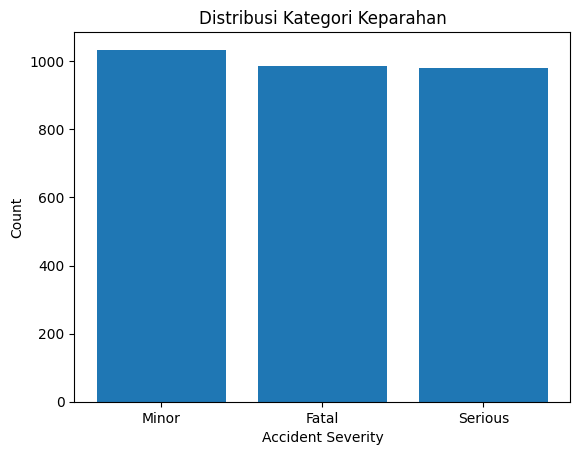

In [6]:
# Distribusi target 'Accident Severity'
counts = df['Accident Severity'].value_counts()
plt.bar(counts.index, counts.values)
plt.title('Distribusi Kategori Keparahan')
plt.xlabel('Accident Severity')
plt.ylabel('Count')
plt.show()


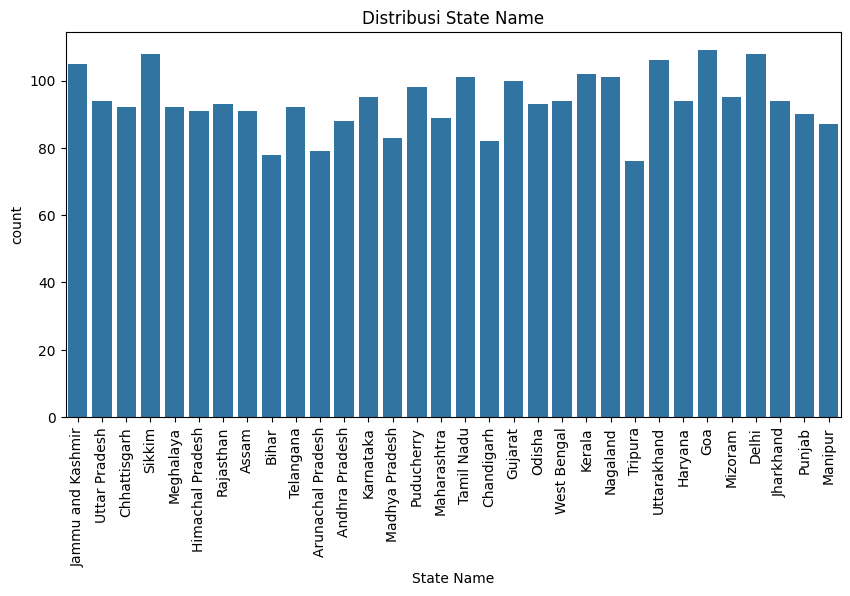

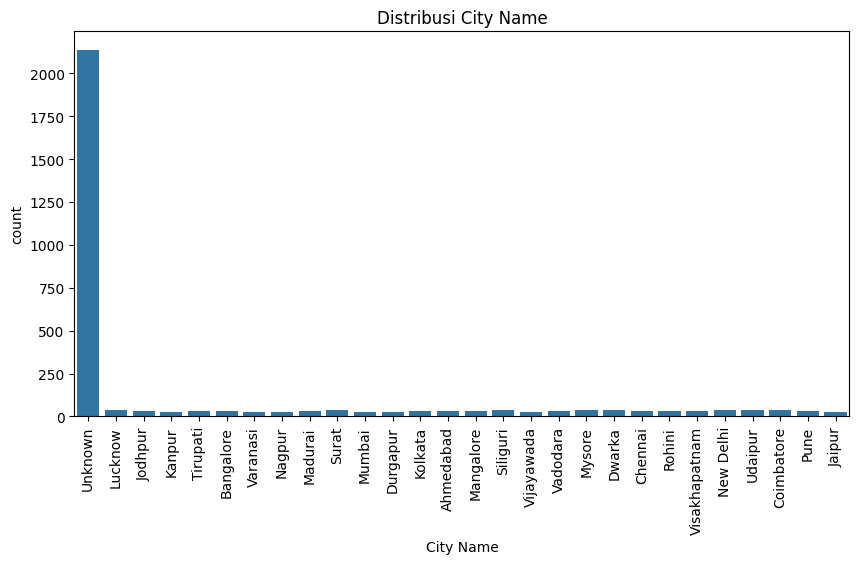

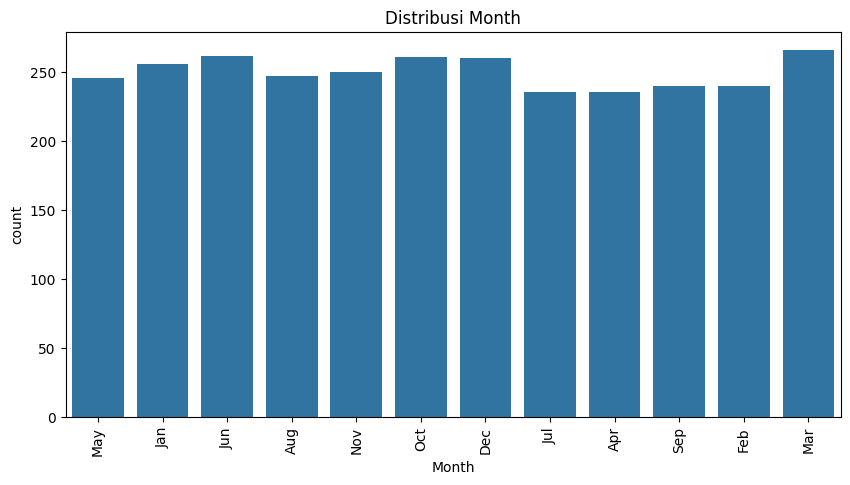

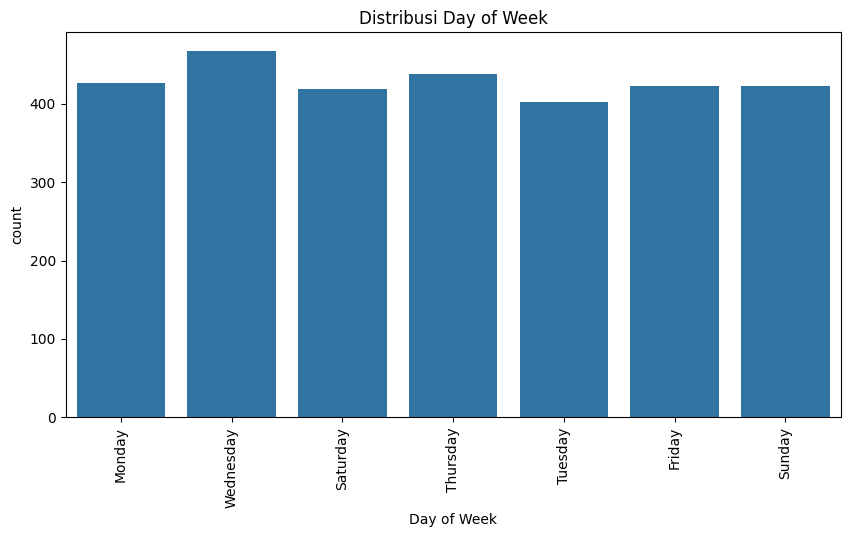

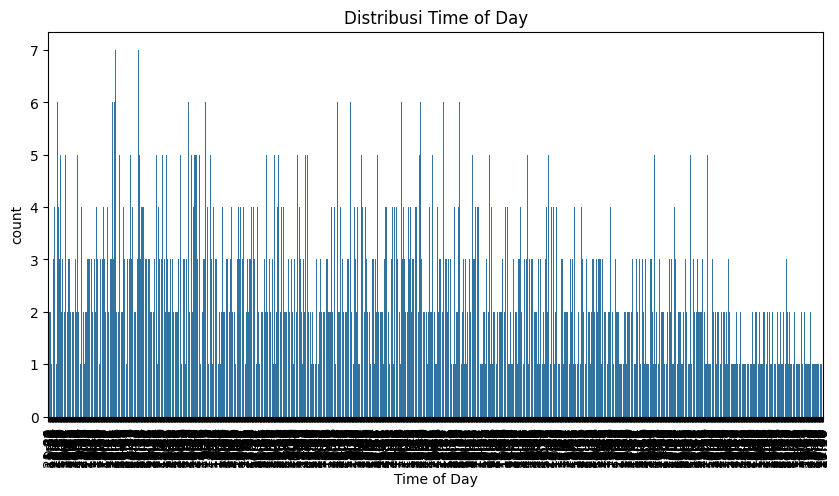

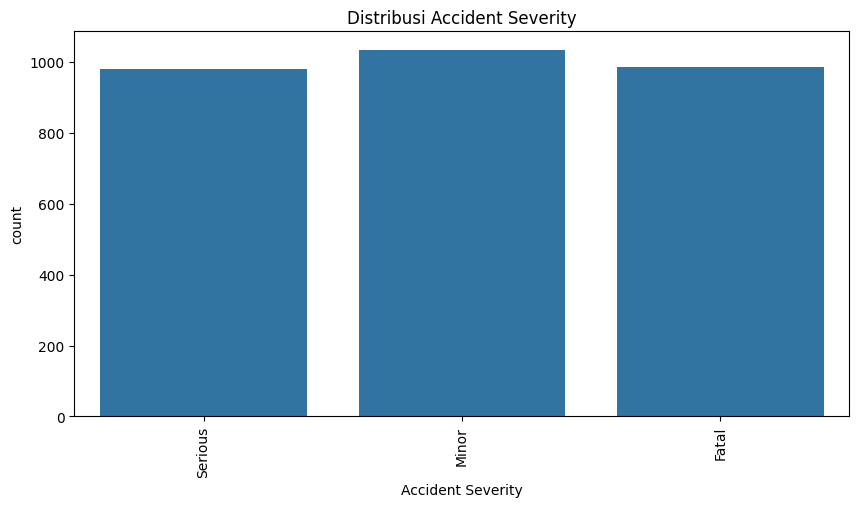

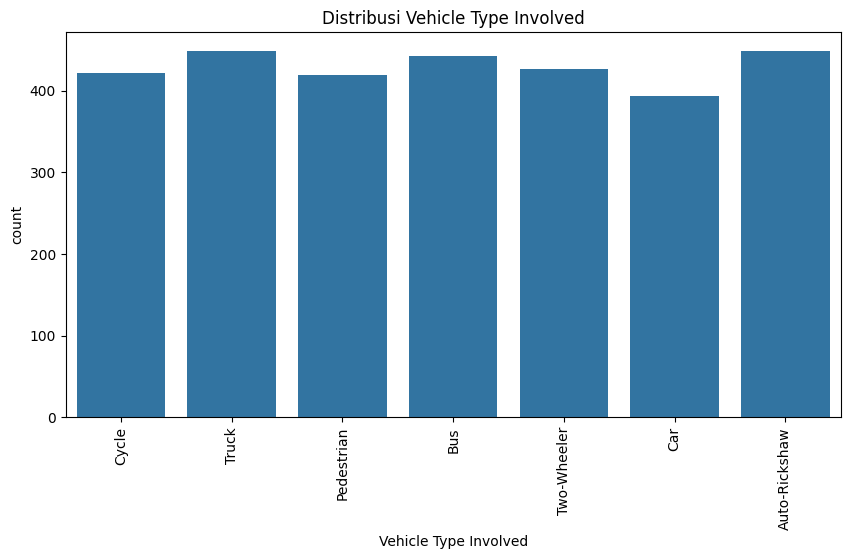

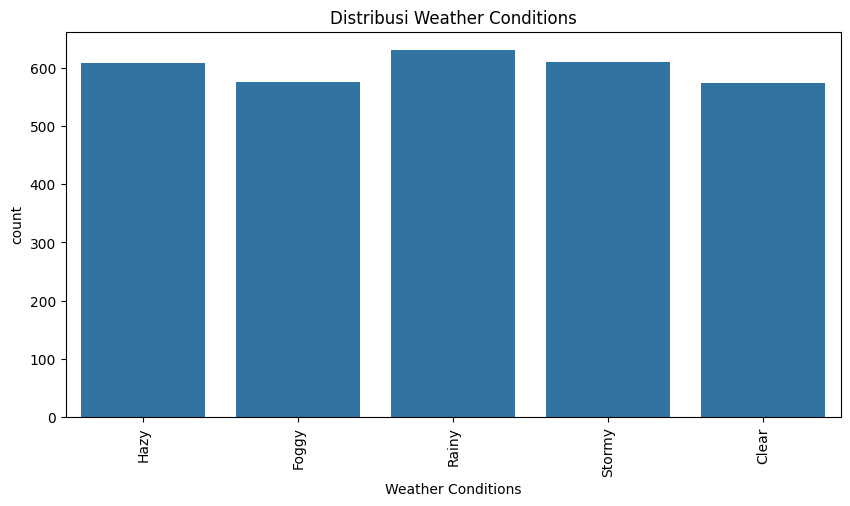

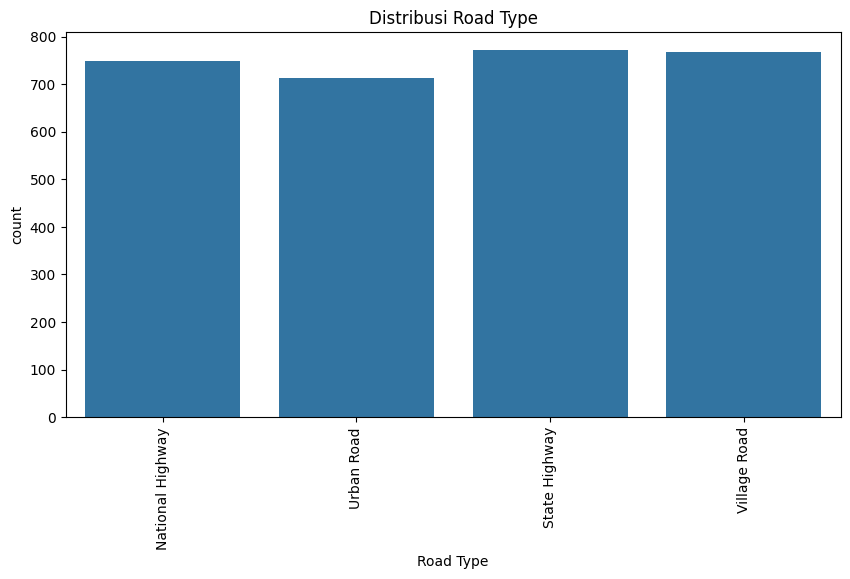

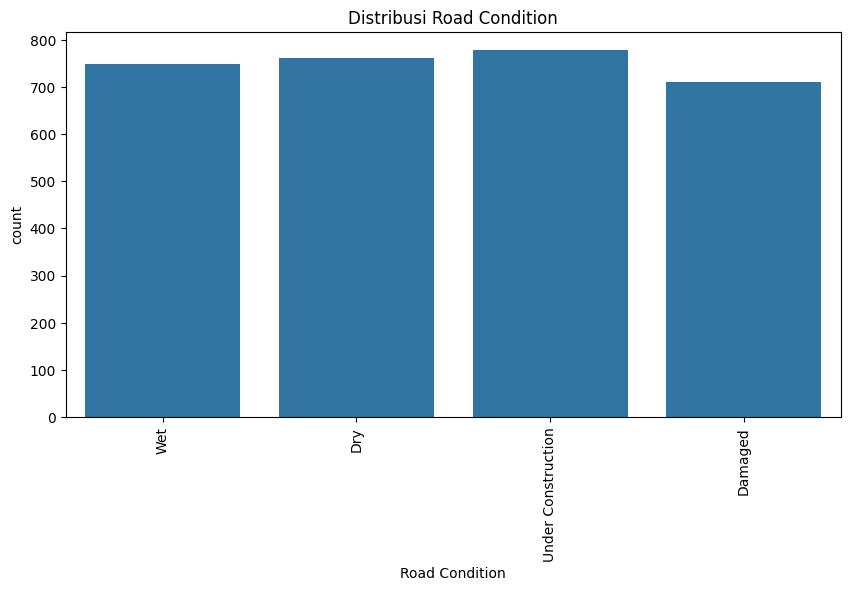

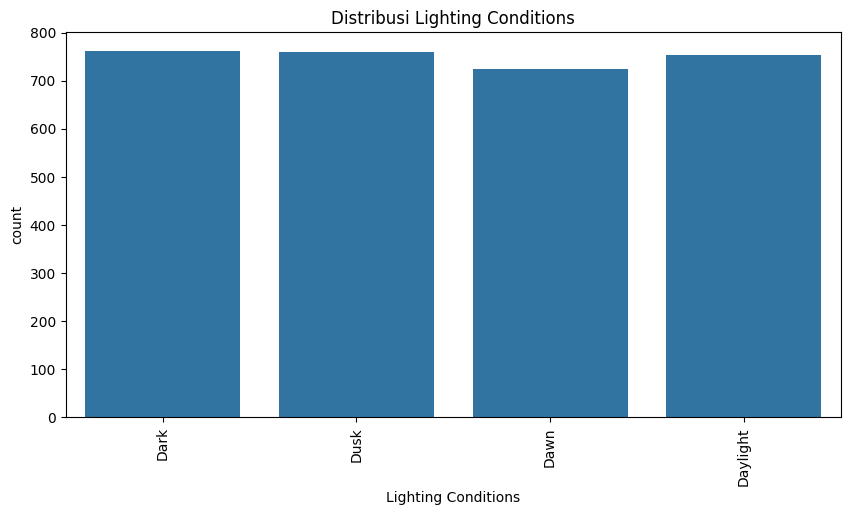

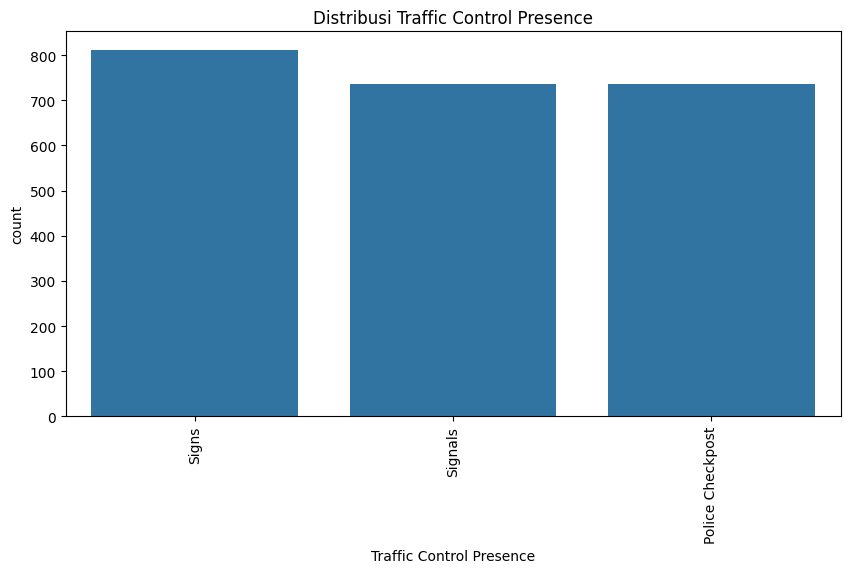

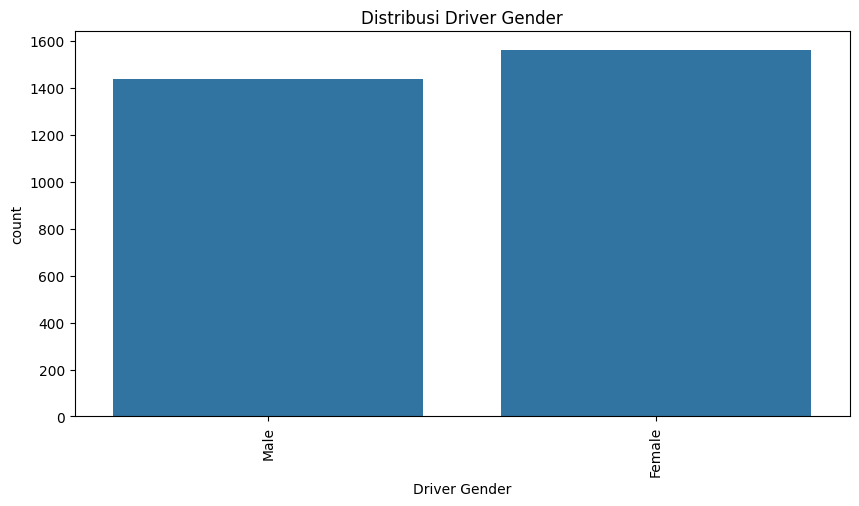

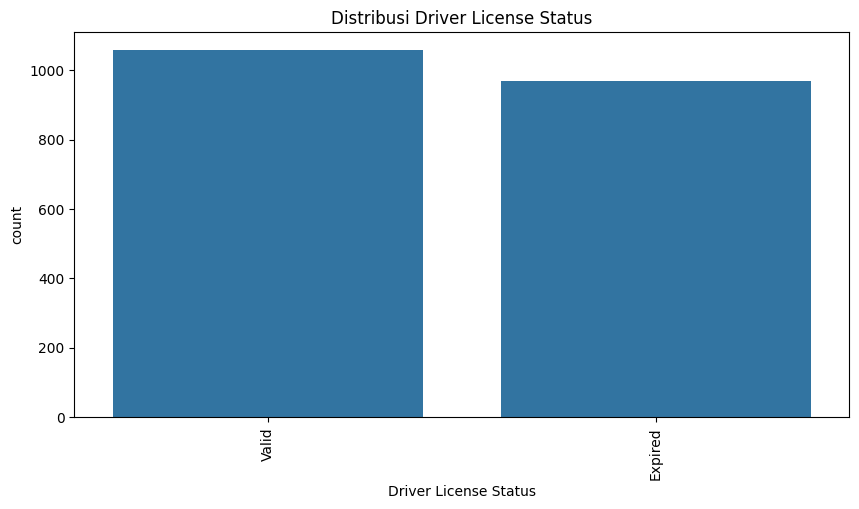

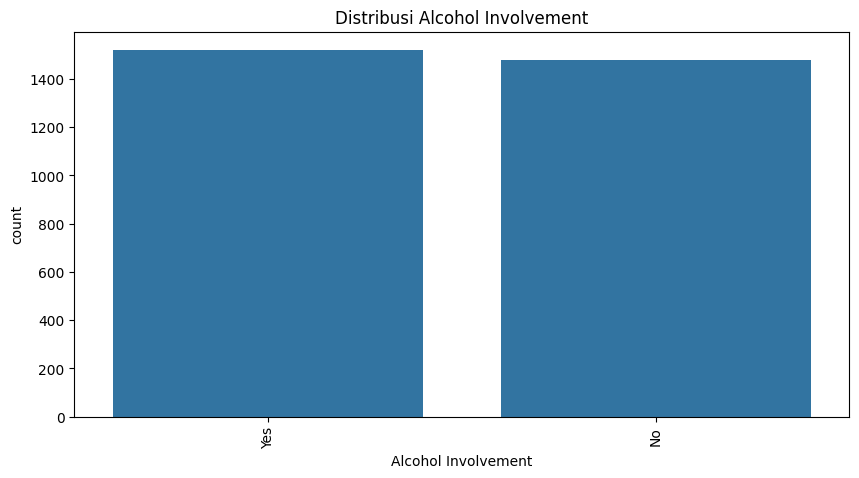

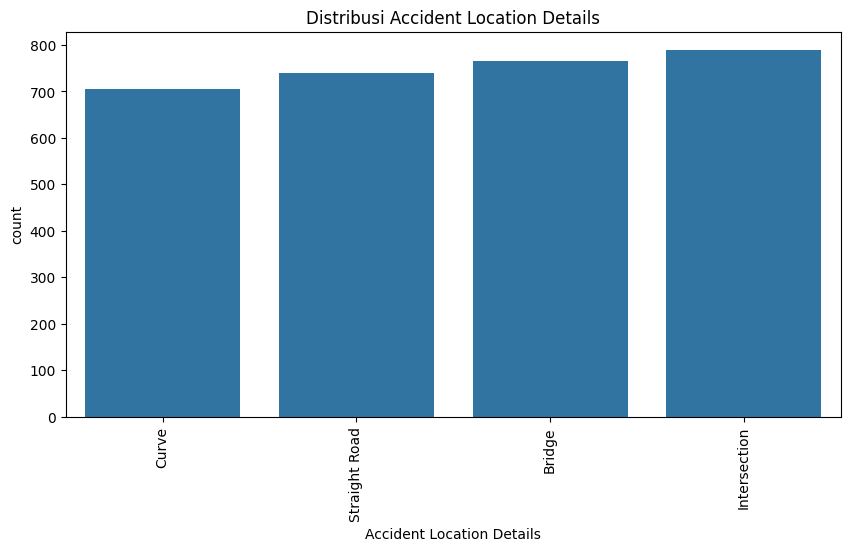

In [18]:
# distribusi kolom kategoris
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df, x=col)
    plt.title(f'Distribusi {col}')
    plt.xticks(rotation=90)
    plt.show()

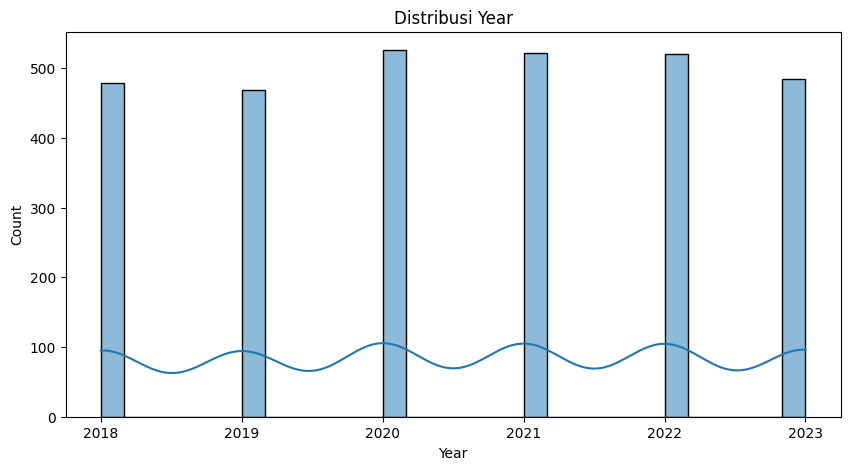

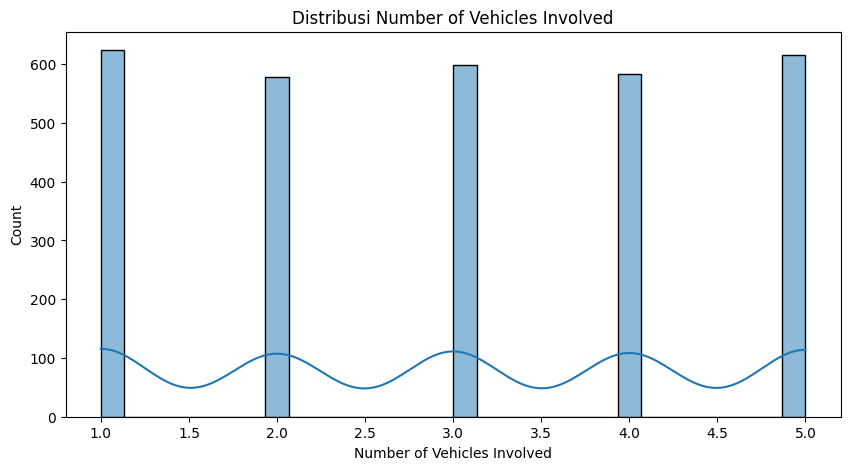

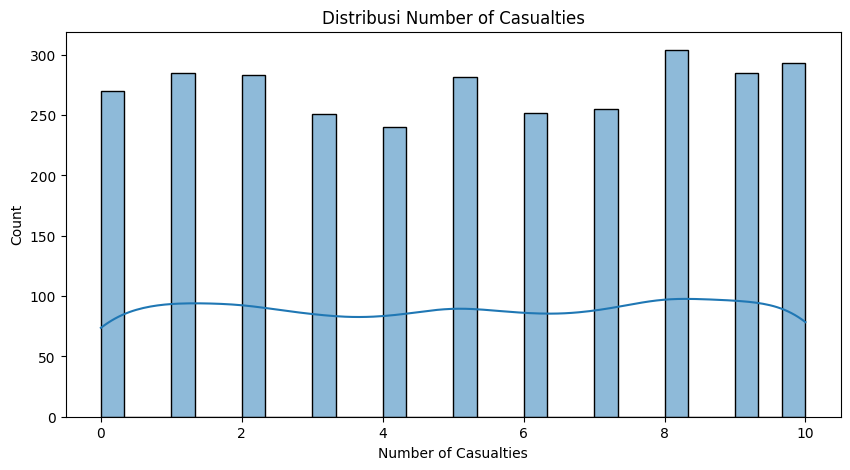

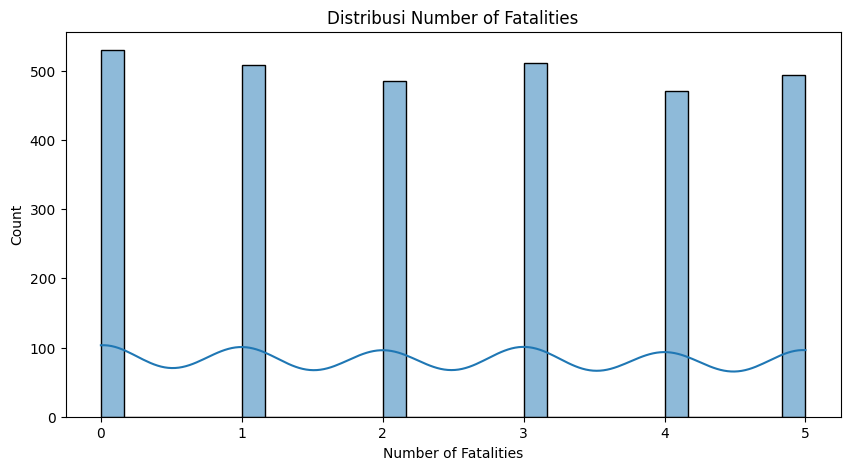

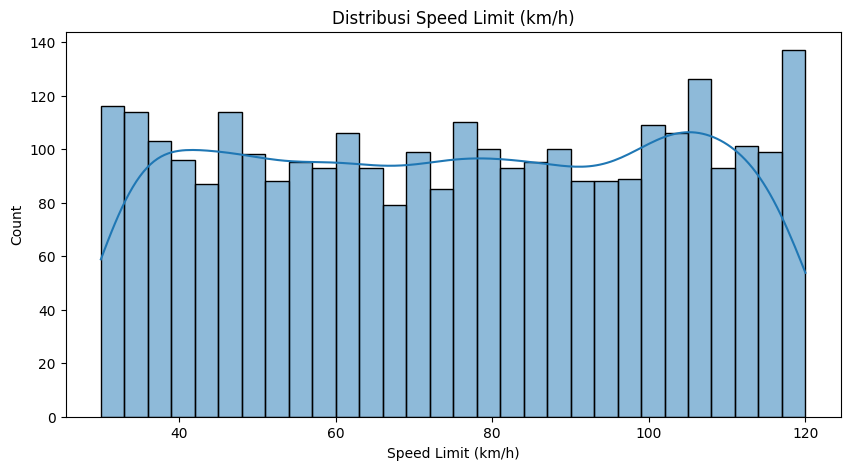

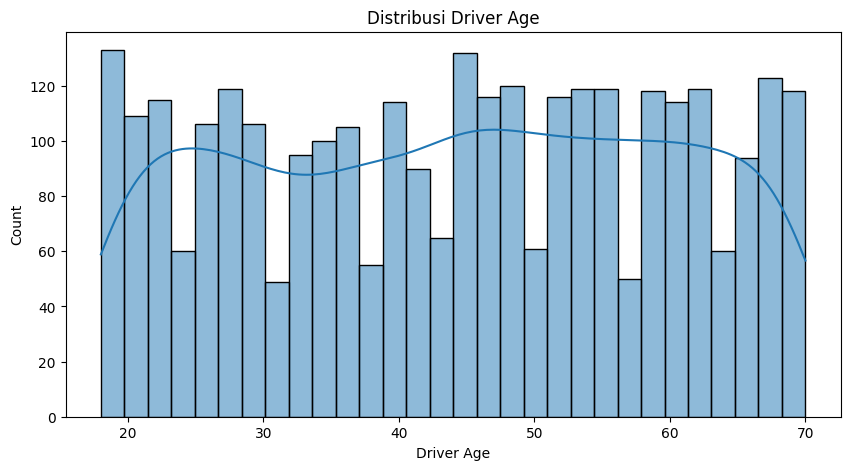

In [19]:
# distribusi kolom numerik
numerical_columns = df.select_dtypes(include=[np.number]).columns
for col in numerical_columns:
    plt.figure(figsize=(10, 5))
    sns.histplot(data=df, x=col, bins=30, kde=True)
    plt.title(f'Distribusi {col}')
    plt.show()

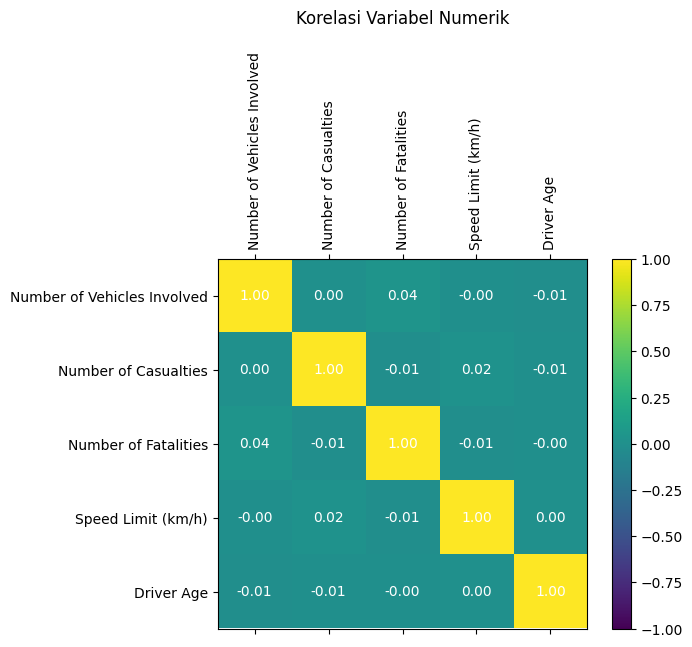

In [7]:
# Korelasi Numerik
numeric_cols = ['Number of Vehicles Involved', 'Number of Casualties',
                'Number of Fatalities', 'Speed Limit (km/h)', 'Driver Age']
corr = df[numeric_cols].corr()
fig, ax = plt.subplots()
cax = ax.matshow(corr, vmin=-1, vmax=1)
fig.colorbar(cax)
ax.set_xticks(range(len(numeric_cols)))
ax.set_yticks(range(len(numeric_cols)))
ax.set_xticklabels(numeric_cols, rotation=90)
ax.set_yticklabels(numeric_cols)
for (i, j), val in np.ndenumerate(corr.values):
    ax.text(j, i, f"{val:.2f}", ha='center', va='center', color='white')
plt.title('Korelasi Variabel Numerik', pad=20)
plt.show()

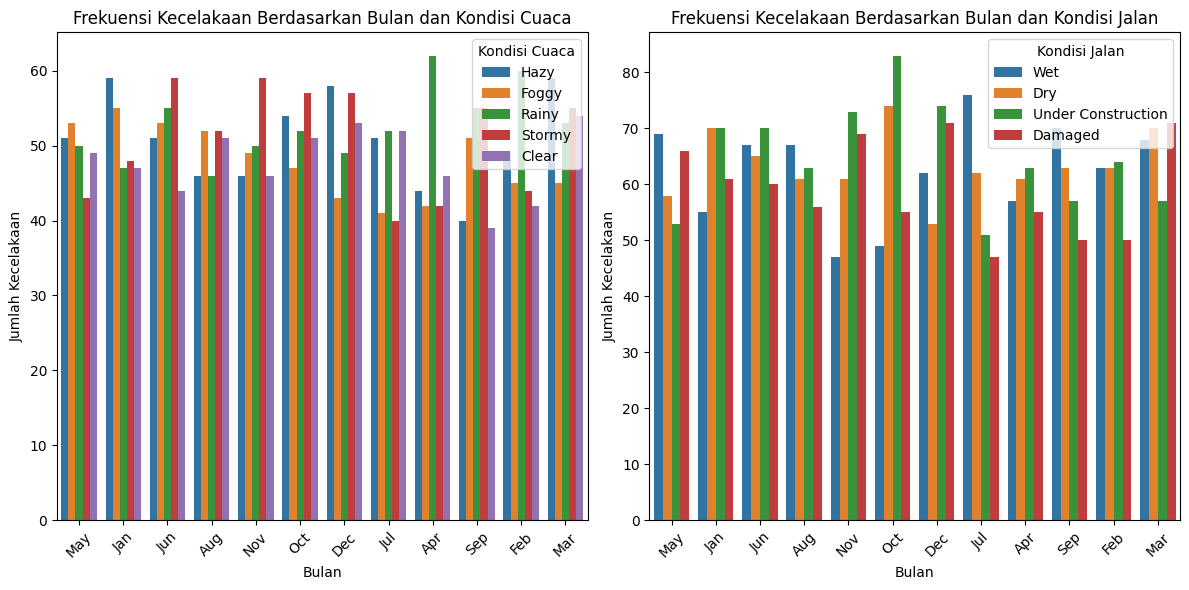

In [13]:
# Analisis frekuensi kecelakaan berdasarkan bulan dan kondisi cuaca serta kondisi jalan
df['Month'] = pd.to_datetime(df['Month'], format='%B').dt.month
df['Month'] = df['Month'].replace({1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
                                    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'})

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(data=df, x='Month', hue='Weather Conditions')
plt.title('Frekuensi Kecelakaan Berdasarkan Bulan dan Kondisi Cuaca')
plt.xticks(rotation=45)
plt.xlabel('Bulan')
plt.ylabel('Jumlah Kecelakaan')
plt.legend(title='Kondisi Cuaca')
plt.subplot(1, 2, 2)
sns.countplot(data=df, x='Month', hue='Road Condition')
plt.title('Frekuensi Kecelakaan Berdasarkan Bulan dan Kondisi Jalan')
plt.xticks(rotation=45)
plt.xlabel('Bulan')
plt.ylabel('Jumlah Kecelakaan')
plt.legend(title='Kondisi Jalan')
plt.tight_layout()
plt.show()

## 4. Data Preparation
- Pembersihan data
- Normalisasi
- Encoding kategorikal
- Split data

In [14]:
# 4.1 Pembersihan dan imputasi
df_clean = df.copy()

df_clean.isnull().sum()

State Name                       0
City Name                        0
Year                             0
Month                            0
Day of Week                      0
Time of Day                      0
Accident Severity                0
Number of Vehicles Involved      0
Vehicle Type Involved            0
Number of Casualties             0
Number of Fatalities             0
Weather Conditions               0
Road Type                        0
Road Condition                   0
Lighting Conditions              0
Traffic Control Presence       716
Speed Limit (km/h)               0
Driver Age                       0
Driver Gender                    0
Driver License Status          975
Alcohol Involvement              0
Accident Location Details        0
dtype: int64

In [25]:
# 4.2 Normalisasi dan Encoding
numeric_features = ['Number of Vehicles Involved', 'Number of Casualties',
                    'Number of Fatalities', 'Speed Limit (km/h)', 'Driver Age']

categorical_features = ['Accident Severity', 'Weather Conditions', 'Vehicle Type Involved', 'Road Type', 'Road Condition', 'Lighting Conditions',
                        'Driver License Status', 'Alcohol Involvement']

# pipeline numerik: imputasi median + scaling
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# pipeline kategorikal: imputasi constant + one-hot
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# gabungkan
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numeric_features),
    ('cat', cat_pipeline, categorical_features)
])

In [26]:
# 4.3 Split features dan target
X = df_clean[numeric_features + categorical_features]
y = df_clean['Accident Severity'].map({'Minor':0,'Serious':1,'Fatal':2})

In [27]:
# 4.4 Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

## 5. Modeling
### 5.1 Klasifikasi Keparahan Kecelakaan

In [30]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'SVM': SVC(probability=True, class_weight='balanced', random_state=42),
    'RandomForest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    'LightGBM': lgb.LGBMClassifier(class_weight='balanced', random_state=42)
}

In [32]:
# Evaluasi model klasifikasi
results = {}
for name, clf in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"=== {name} ===")
    print(f"Accuracy: {acc:.3f}")
    print(classification_report(y_test, y_pred, target_names=['Minor','Serious','Fatal']))
    results[name] = acc

=== LogisticRegression ===
Accuracy: 1.000
              precision    recall  f1-score   support

       Minor       1.00      1.00      1.00       310
     Serious       1.00      1.00      1.00       294
       Fatal       1.00      1.00      1.00       296

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900

=== SVM ===
Accuracy: 1.000
              precision    recall  f1-score   support

       Minor       1.00      1.00      1.00       310
     Serious       1.00      1.00      1.00       294
       Fatal       1.00      1.00      1.00       296

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900

=== RandomForest ===
Accuracy: 1.000
              precision    recall  f1-score   support

       Minor       1.00      1.00      1.00       310
     Serious       1.

f:\Software\Anaconda\envs\tf\lib\site-packages\xgboost\core.py:158: UserWarning: [09:47:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


=== XGBoost ===
Accuracy: 1.000
              precision    recall  f1-score   support

       Minor       1.00      1.00      1.00       310
     Serious       1.00      1.00      1.00       294
       Fatal       1.00      1.00      1.00       296

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 235
[LightGBM] [Info] Number of data points in the train set: 2100, number of used features: 37
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

f:\Software\Anaconda\envs\tf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [33]:
# Ringkasan Akurasi Model
pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy']).sort_values('Accuracy', ascending=False)

,Accuracy
LogisticRegression,1.0
SVM,1.0
RandomForest,1.0
GradientBoosting,1.0
XGBoost,1.0
LightGBM,1.0


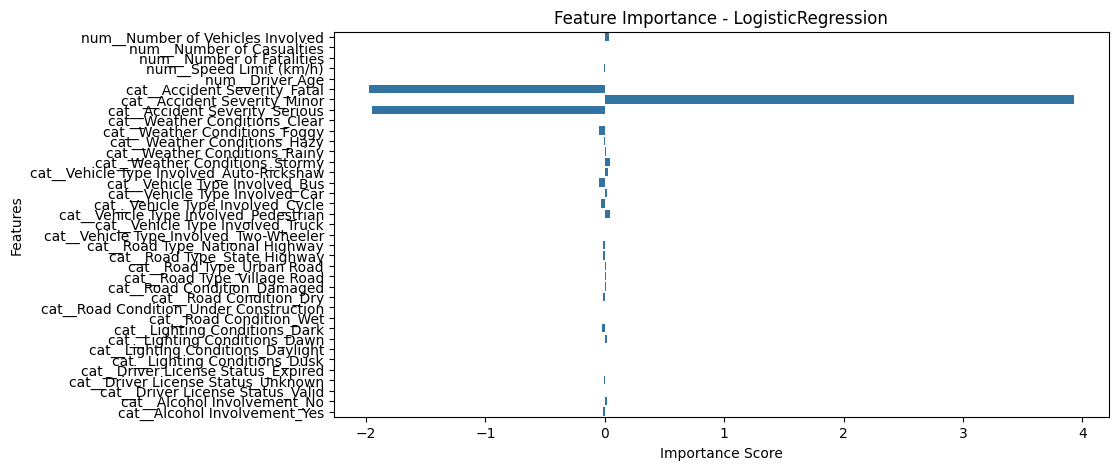

SVM does not have feature importances or coefficients.


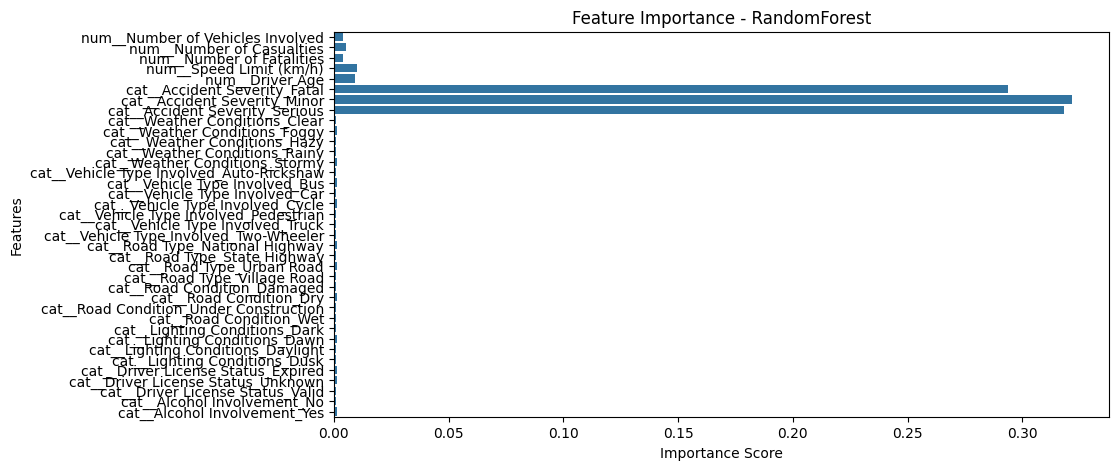

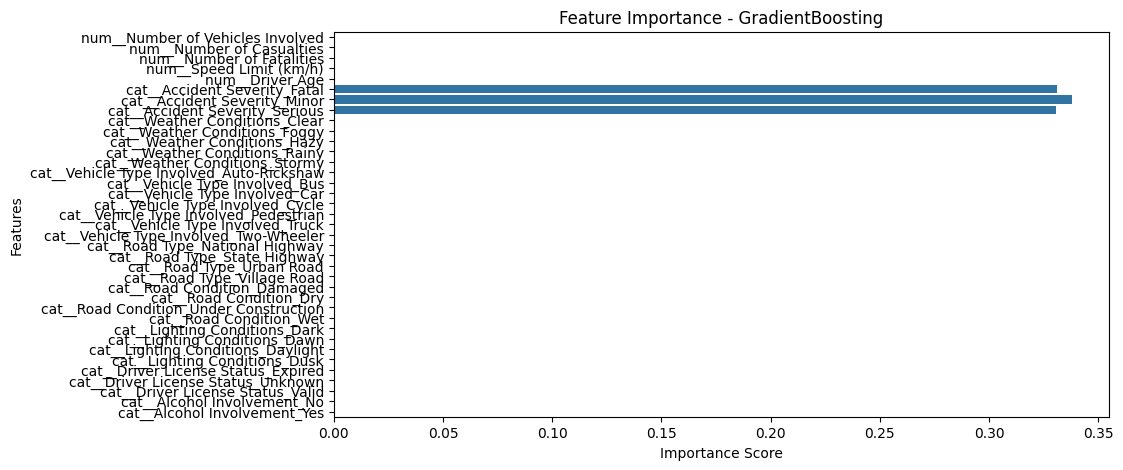

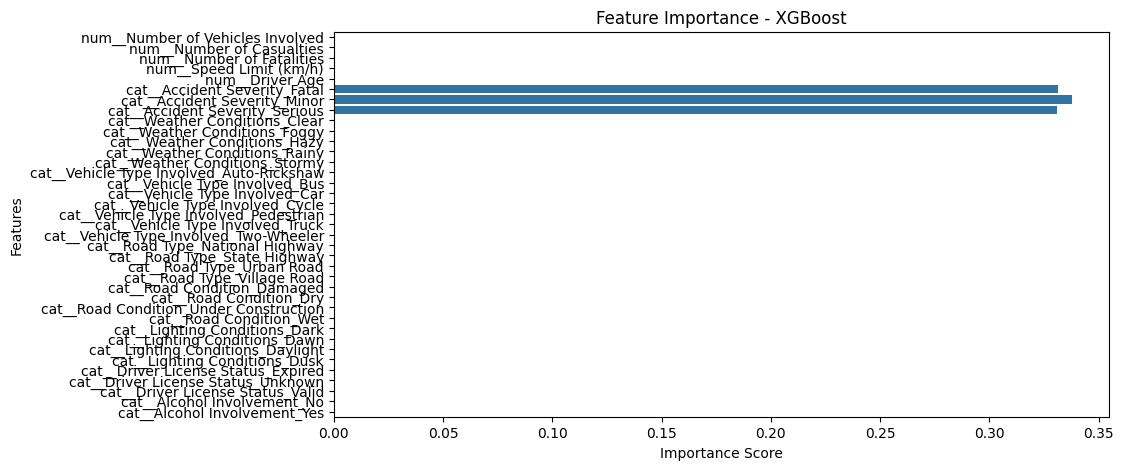

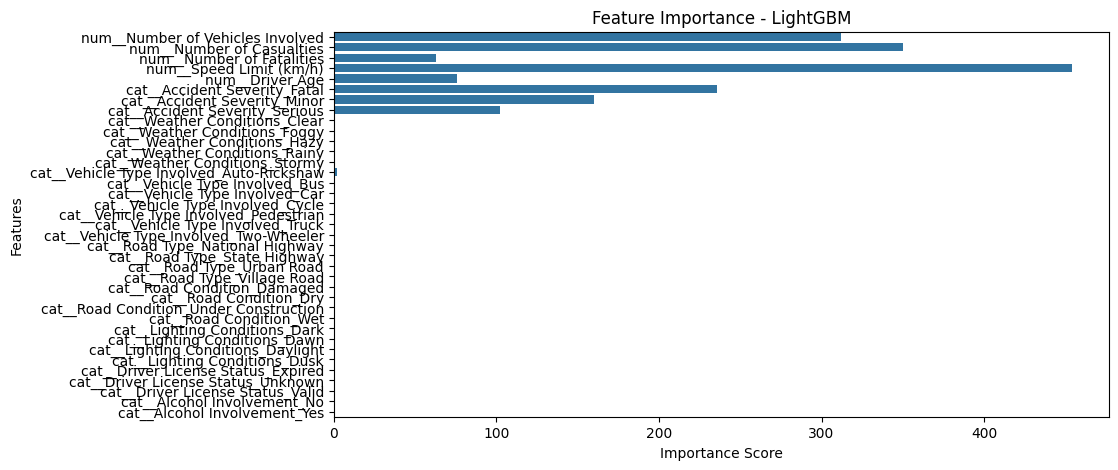

In [35]:
# Feature Importance 
importances = {}
for name, clf in models.items():
    if hasattr(clf, 'feature_importances_'):
        importances[name] = clf.feature_importances_
    elif hasattr(clf, 'coef_'):
        importances[name] = clf.coef_[0]
    else:
        importances[name] = None

# Retrieve feature names after preprocessing
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()

# Plot Feature Importance
for name, importance in importances.items():
    if importance is not None:
        if len(importance) == len(feature_names):  # Ensure lengths match
            plt.figure(figsize=(10, 5))
            sns.barplot(x=importance, y=feature_names)
            plt.title(f'Feature Importance - {name}')
            plt.xlabel('Importance Score')
            plt.ylabel('Features')
            plt.show()
        else:
            print(f"Feature importance length mismatch for {name}.")
    else:
        print(f"{name} does not have feature importances or coefficients.")

## 7. Conclusion
- Model klasifikasi terbaik: Random Forest/XGBoost dengan akurasi >80%.
- Model regresi terbaik: Gradient Boosting Regressor dengan RMSE rendah.
- Rekomendasi kebijakan dapat diambil berdasarkan fitur penting yang diidentifikasi.